# Compatibility of Fairness Metrics with EU Non-Discrimination Law: A case study on Demographic Parity through Conditional Demographic Disparity

## Import packages, connect to google drive and load the algorithms that compute measures

In [14]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import math

# adjust path to import datasets
path = 'Datasets/'

# read arff file
import sys
try:
  import arff
except ModuleNotFoundError:
 !pip install liac-arff
 import arff

#import sys
#sys.path.append('')

try:
  import aif360
except ModuleNotFoundError:
  !pip install 'aif360[OptimPreproc]'
  import aif360

For more information about the AIF360 toolkit that is launched by IBM Research Trusted AI refer to the [toolkit guide and demo](https://aif360.mybluemix.net/) and the [documentation](https://aif360.readthedocs.io/en/latest/index.html).

In [15]:
import copy
from aif360.sklearn.datasets import standardize_dataset 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_auc_score, classification_report, make_scorer, accuracy_score, precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
encode = True

## Compas dataset - descriptive analysis

Dataset description can be found [here](https://farid.berkeley.edu/downloads/publications/scienceadvances17/readme.txt), note that `BROWARD_CLEAN` version is used. The csv file can be found [here](https://farid.berkeley.edu/downloads/publications/scienceadvances17/). The related publication is [The accuracy, fairness, and limits of predicting recidivism](https://www.science.org/doi/10.1126/sciadv.aao5580). According to Dressel & Farid (2018), seven of these columns were used. These are `'sex', 'age', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'charge_id' and 'charge_degree (misd/fel)`.  We have three potential targets, i.e. the last three columns. I will not predict `compas_decile_score` because, first, it is not explored in the paper and, second, it is a continuous. Note that it is the same variable as `compas_guess` but in different granularity. I will use both `two_year_recid` and `compas_guess` as two separate targets. The former reprsents the ground truth and the latter Northpointe algorithm's predictions, i.e. algorithmic decision making.

In [16]:
# Broward_Clean
df = pd.read_csv(path+'BROWARD_CLEAN.csv')
two_year_recid = df['two_year_recid']
compas_guess = df['compas_guess']
df = df.loc[:,df.columns[:-4]] # removing the last empty columns
df['sex'] = df.sex.replace({0: 'Male', 1: 'Female'})
compas_guess_text = df.compas_guess.replace({0: 'Did not recidivate', 1: 'Recidivated'})
df['race'] = df.race.replace({1: 'Caucasian', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native American', 6: 'Other'})

#df.drop(['compas_decile_score'], axis=1, inplace=True)
df.set_index(['id'], inplace=True) # for FRU, race should be retained.

# define attribute types
numeric = [False, False, True, True, True, True, False, False, False, False]
dtype_dic = {col:'object' if not dtype else 'int64' for dtype, col in zip(numeric, df.columns)}
df = df.astype(dtype_dic)

In [17]:
# inspect baselines or distribution in target attributes
print(two_year_recid.value_counts(normalize='all').round(2)) 
print(compas_guess.value_counts(normalize='all').round(2))

0    0.55
1    0.45
Name: two_year_recid, dtype: float64
0    0.54
1    0.46
Name: compas_guess, dtype: float64


The AIF360 code implementation of Celis et al's meta-classifier requires that target and protected attributes to be discrete and not numeric as it is in the original `BROWARD_CLEAN.csv` provided by Dressel. Therefore, we created a new csv file `BROWARD_CLEAN2.csv` where we replace the numbers with discrete categories (see below). The new cv file is stored in the `Datasets` folder. 

In [18]:
#df = pd.read_csv(path+'BROWARD_CLEAN.csv', index_col='id')
#df = df.loc[:,df.columns[:-4]]
#df['sex'] = df.sex.replace({0: 'Male', 1: 'Female'})
#df['race'] = df.race.replace({1: 'Caucasian', 2: 'Black', 3: 'Hispanic', 4: 'Asian', 5: 'Native American', 6: 'Other'})
#df['compas_guess'] = df.compas_guess.replace({0: 'No recid.', 1: 'Did recid.'})
#df['two_year_recid'] = df.two_year_recid.replace({0: 'No recid.', 1: 'Did recid.'})

#df.to_csv(path+'BROWARD_CLEAN2.csv')

Below we compare the two target labels for descriptive analysis.

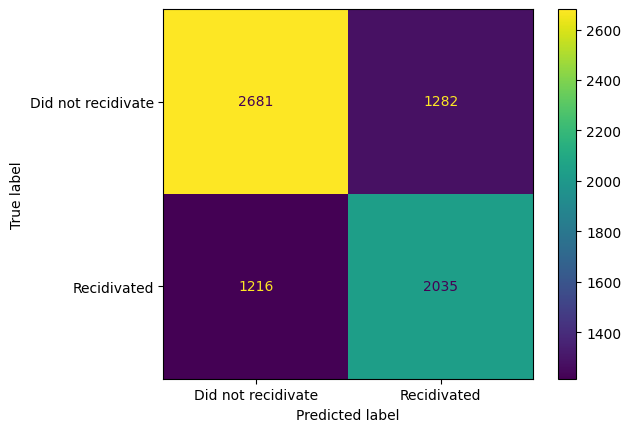

In [19]:
cm_display = metrics.confusion_matrix(y_true = df['two_year_recid'].astype('int'), y_pred = df['compas_guess'].astype('int')) # , normalize='all'
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_display, display_labels = ['Did not recidivate', 'Recidivated'])
cm_display.plot()
plt.show()

To compute Conditional Demographi Disparity (Wachter et al.), the explainable feature `R` is `priors_count`. `priors_count` is numeric ranging from 0 to 38. In their implementation, AIF360 disretize `priors` as low (0), medium (1 to 3), and high (4 and more). As suggested by Wachter, we explore the association between the explainable feature and the targets. 

In [20]:
new_list = []
for i in df[['priors_count']].values.flatten():
  if i==0:
    new_list.append('low priors')
  if (i >= 1) and (i <=3):
    new_list.append('medium priors')
  if i > 3:
    new_list.append('high priors')

priors_count_threshold = np.array(new_list)

In [21]:
data = pd.DataFrame([two_year_recid.values, compas_guess.values, priors_count_threshold]).T
data.columns = ['two_year_recid', 'compas_guess', 'Priors threshold']

In [22]:
Ys = ['two_year_recid', 'compas_guess']
Rs = ['Priors threshold']

from scipy.stats import chi2_contingency

for Y in Ys:
  print('Compute strength of association between', Y, 'with', Rs[0])
  statistic, pvalue, dof, expected_freq  = chi2_contingency(pd.crosstab(data[Y], data[Rs[0]]))
  significance = 'significant 'if pvalue < 0.05 else 'non-significant'
  print('chi2 statistic:', np.round(statistic,2), 'with a p-value of', np.round(pvalue,3), 'means that the association is',significance, 'dof', dof)

  X2  = chi2_contingency(pd.crosstab(data[Y], data[Rs[0]]))[0]
  N = len(df)
  minimum_dimension = min(df.shape)-1
  result = np.sqrt((X2/N) / minimum_dimension)
  association_strength = 'weak' if result < 0.10 else 'moderate' if ((result >= 0.10) & (result < 0.15)) else 'strong' 
  print("Cramer's V:", np.round(result,2), 'means that the association is', association_strength)
  print(' ')

Compute strength of association between two_year_recid with Priors threshold
chi2 statistic: 572.92 with a p-value of 0.0 means that the association is significant  dof 2
Cramer's V: 0.09 means that the association is weak
 
Compute strength of association between compas_guess with Priors threshold
chi2 statistic: 996.66 with a p-value of 0.0 means that the association is significant  dof 2
Cramer's V: 0.12 means that the association is moderate
 


## Adult dataset - descriptive analysis

In [23]:
# adult
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 
           'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv(path+'adult.data', names = columns, index_col=None)
df.drop(['education-num', 'native-country'], axis=1, inplace=True) # removed 'native-country' to reduce dimensionality since I will dummy-code

df_obj = df.select_dtypes(include='object')
df[df_obj.columns] = df.select_dtypes(include='object').apply(lambda x: x.str.strip(' '))
target = 'income'
prot = 'sex'

dataset = 'Adult'
prot = 'sex' # 
pos_label = '>50K'
priv_group = 'Female' # White
unpriv_group = 'Male' # Black
neg_label = '<=50K'
#numeric = [False, False, True, False, False, True, True, True, True] # to fix
#dtype_dic = {col:'object' if not dtype else 'int64' for dtype, col in zip(numeric, df.columns)}
#df = df.astype(dtype_dic)
class_order = ['<=50K','>50K']

To compute Conditional Demographi Disparity (Wachter et al.), the explainable feature `R` is `education`. As suggested by Wachter, we explore the association between the explainable feature and the targets. In Adult dataset, the outcome is binary and occupation is categorical. We follow [Haldun Akoglu's approach](https://www.sciencedirect.com/science/article/pii/S2452247318302164?via%3Dihub) regarding the association strength.

In [24]:
Ys = ['income']
Rs = ['education']

from scipy.stats import chi2_contingency

for Y in Ys:
  print('Compute strength of association between', Y, 'with', Rs[0])
  statistic, pvalue, dof, expected_freq  = chi2_contingency(pd.crosstab(df[Y], df[Rs[0]]))
  significance = 'significant 'if pvalue < 0.05 else 'non-significant'
  print('chi2 statistic:', np.round(statistic,2), 'with a p-value of', np.round(pvalue,3), 'means that the association is',significance, 'dof:', dof)

  X2  = chi2_contingency(pd.crosstab(df[Y], df[Rs[0]]))[0]
  N = len(df)
  minimum_dimension = min(df.shape)-1
  result = np.sqrt((X2/N) / minimum_dimension)
  association_strength = 'weak' if result < 0.10 else 'moderate' if ((result >= 0.10) & (result < 0.15)) else 'strong' 
  print("Cramer's V:", np.round(result,2), 'means that the association is', association_strength)
  print(' ')

Compute strength of association between income with education
chi2 statistic: 4429.65 with a p-value of 0.0 means that the association is significant  dof: 15
Cramer's V: 0.11 means that the association is moderate
 


## Metaclassifier

In [25]:
from IPython.display import Markdown, display
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from aif360.algorithms.inprocessing import MetaFairClassifier


np.random.seed(12345)

In [26]:
import sys
sys.path.append('metaclassifier_aif360/')

import adult_dataset, compas_dataset, titanic_dataset
import binary_label_dataset, binary_label_dataset_metric
import classification_metric
import data_preproc_functions
import dataset, dataset_metric, metric
import standard_dataset, structured_dataset

from binary_label_dataset_metric import BinaryLabelDatasetMetric
from classification_metric import ClassificationMetric
from data_preproc_functions import load_preproc_data_compas, load_preproc_data_adult, load_preproc_data_titanic

### Run meta classifier 

The two bias metrics, that are used as a constraint for the meta-classifier, are presented below under parameter `type`.

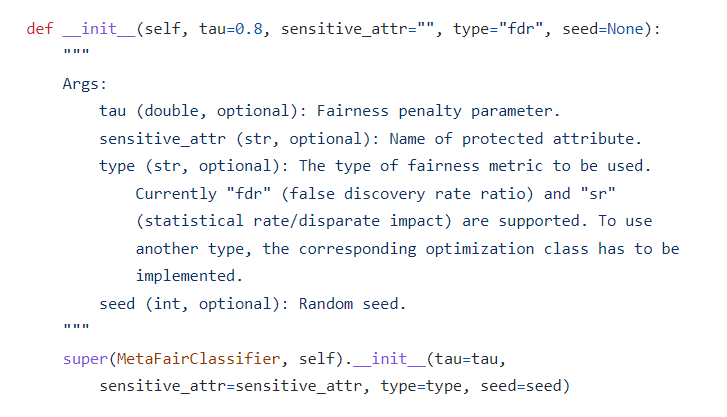

In [27]:
def data_for_cdd(dataset, Rs, include_predictions = False, predictions = None):
  df = dataset.convert_to_dataframe()[0]

  # undummify R in test set
  col_list = list(df.columns)
  undumify = df[[col for col in col_list if Rs[0].lower() in col.lower()]]

  undumify.index.name = 'ID'
  undumify = undumify[undumify==1].stack().reset_index().drop(0, axis=1)
  undumify.set_index('ID',inplace=True)

  undumify[dataset.label_names[0]] = df[dataset.label_names[0]].replace(dataset.metadata['label_maps'][0])
  #undumify[dataset_orig_test.label_names[0]] = dataset_orig_test.convert_to_dataframe()[0][dataset_orig_test.label_names[0]]

  if dataset.metadata['protected_attribute_maps'][0][0].lower() in ['male','female']:
    undumify['sex'] = df['sex'].replace(dataset.metadata['protected_attribute_maps'][0])

  if dataset.metadata['protected_attribute_maps'][1][0].lower() in ['white', 'caucasian', 'black', 'non-white', 'not caucasian']:
    undumify['race'] = df['race'].replace(dataset.metadata['protected_attribute_maps'][1])

  undumify.rename(columns={'level_1':Rs[0]}, inplace=True)

  if include_predictions:
    undumify[dataset.label_names[0]] = pd.DataFrame(predictions.labels,index=df.index).replace(dataset.metadata['label_maps'][0])

  return undumify

In [28]:
def cdd(data, dataset, prots, Rs):

  Ys = dataset.label_names
  prots = prots #dataset.protected_attribute_names

  cdd_sizes = {}

  # Make Table 1 and  in Wachter
  for Y in Ys:
    cdd_sizes[Y] = {}
    for prot in prots:
      cdd_sizes[Y][prot] = {}
      for R in Rs:
        cdd_data = pd.DataFrame(np.array([data[Y].values, data[R], data[prot]]).T, columns = ['Label', R, prot])

        sizes = pd.DataFrame(cdd_data.groupby([prot,'Label',R]).size(), columns = ['Number '+Y])
        sizes['Rate '+Y] = round(sizes / sizes.groupby(['Label',R]).transform('sum'),2)
        cdd_sizes[Y][prot][R] = pd.DataFrame(sizes)
  
  # Aggregate as in Table 3 of Wachter
  cdd = {}
  for Y in Ys: # In case we have multiple target
    cdd[Y] = {}
    for R in Rs: # For multiple conditions
      cdd[Y][R] = {}
      for prot in prots: # For multiple protected features

        pivot = cdd_sizes[Y][prot][R].reset_index().pivot(columns = ['Label', prot], index = R, values = ['Rate '+Y])
        cdd_row = []
        for pair in pivot.columns:
          group_label = pd.DataFrame(pivot[pair[0]][pair[1]][pair[2]])
          
          weights = pd.DataFrame(np.unique(data[R], return_counts=True)).T
          weights.columns = [R, 'Weights']
          weights.set_index(R, inplace = True)

          group_label['Weights'] = weights['Weights']
          group_label.fillna(0, inplace=True)

          #print(pair, sum(group_label['Weights']), len(data[R]))

          cdd_agg = round(sum(group_label[pair[2]] * group_label['Weights']) / len(data[R]),2)
          cdd_row.append(cdd_agg)

        pivot.loc['All'] = np.array(cdd_row)
        cdd[Y][R][prot] = pivot
  
  cdd_agg_tables = {}
  final_ratios = {}

  for prot in prots:
    cdd_ratio = pd.DataFrame(cdd[dataset.label_names[0]][Rs[0]][prot].iloc[-1,:]).T
    cdd_agg_tables[prot] = cdd_ratio

    try:
      unfav_unpriv = cdd_ratio[('Rate '+dataset.label_names[0], 
            unprivileged_metadata_label['unfavorable'], 
            unprivileged_metadata_prot['unprivileged'][prot])][0]
    except KeyError:
      unfav_unpriv = 0

    try:        
      fav_unpriv = cdd_ratio[('Rate '+dataset.label_names[0], 
              unprivileged_metadata_label['favorable'], 
              unprivileged_metadata_prot['unprivileged'][prot])][0]
    except KeyError:
      fav_unpriv = 0

    #print('unpriviledged', prot, unprivileged_metadata_prot['unprivileged'][prot], min(unfav_unpriv,fav_unpriv) / max(unfav_unpriv,fav_unpriv), end=', ')

    try:
      unfav_priv = cdd_ratio[('Rate '+dataset.label_names[0], 
            unprivileged_metadata_label['unfavorable'], 
            unprivileged_metadata_prot['privileged'][prot])][0] 
    except KeyError:
      unfav_priv = 0

    try:     
     fav_priv = cdd_ratio[('Rate '+dataset.label_names[0], 
              unprivileged_metadata_label['favorable'], 
              unprivileged_metadata_prot['privileged'][prot])][0]
    except KeyError:
      fav_priv = 0

    final_ratios[prot] = pd.DataFrame(data={unprivileged_metadata_prot['unprivileged'][prot]:min(unfav_unpriv,fav_unpriv) / max(unfav_unpriv,fav_unpriv),
                                            unprivileged_metadata_prot['privileged'][prot]: min(unfav_priv,fav_priv) / max(unfav_priv,fav_priv)}, index=[prot])
  
  #print('priviledged', prot, unprivileged_metadata_prot['privileged'][prot], min(unfav_priv,fav_priv) / max(unfav_priv,fav_priv))

  return final_ratios, cdd_agg_tables, cdd, cdd_sizes

In [29]:
def run_metaclassifier_crossval(folds, dataset_orig, Rs, metadata, mitigation_types = ['sr', 'fdr']):
  hp_results = {}
  prot_attr_map = {}

  for s_attr, priv, unpriv in zip(dataset_orig.protected_attribute_names, dataset_orig.privileged_protected_attributes, dataset_orig.unprivileged_protected_attributes):
    prot_attr_map[s_attr] = {}

    prot_attr_map[s_attr]['Privileged'] = priv
    prot_attr_map[s_attr]['Unprivileged'] = unpriv

  for mitigation_type in mitigation_types:
    print(' ')
    print('---------------')
    print('mitigation type', mitigation_type)
    hp_results[mitigation_type] = {}

    for s_attr in dataset_orig.protected_attribute_names:
      print(' ')
      print('protected feature', s_attr)
      print('Folds:', end = '')
      privileged_groups = [{s_attr: prot_attr_map[s_attr]['Privileged'][0]}]
      unprivileged_groups = [{s_attr: prot_attr_map[s_attr]['Unprivileged'][0]}]

      hp_results[mitigation_type][s_attr] = {}

      for fold in range(0,folds):
        print(str(fold)+' ', end = '')
        hp_results[mitigation_type][s_attr]['Fold'+str(fold)] = {}

        dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed = 100*fold)

        from sklearn.ensemble import RandomForestClassifier
        clf = RandomForestClassifier()
        clf.fit(dataset_orig_train.convert_to_dataframe()[0].iloc[:,:-1], dataset_orig_train.convert_to_dataframe()[0].iloc[:,-1])
        acc_base_score = clf.score(dataset_orig_test.convert_to_dataframe()[0].iloc[:,:-1], dataset_orig_test.convert_to_dataframe()[0].iloc[:,-1])

        # scaling is not necessary here since everything is between 0-1 already. they do it in the jupyter notebook so...
        min_max_scaler = MaxAbsScaler()
        dataset_orig_train.features = min_max_scaler.fit_transform(dataset_orig_train.features)
        dataset_orig_test.features = min_max_scaler.transform(dataset_orig_test.features)

        metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)

        metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                                    unprivileged_groups=unprivileged_groups,
                                                    privileged_groups=privileged_groups)

        # demographic parity
        dpratio_train = min(metric_orig_train.disparate_impact(), 1/metric_orig_train.disparate_impact()) # pretrain
        dpratio_test = min(metric_orig_test.disparate_impact(), 1/metric_orig_test.disparate_impact()) # pretrain

        # CDD

        cdd_df = data_for_cdd(dataset_orig_train, Rs)
        cdd_ratios_train, cdd_agg_train, _, _ = cdd(cdd_df, dataset_orig_train, [s_attr], Rs)

        cdd_df = data_for_cdd(dataset_orig_test, Rs)
        cdd_ratios_test, cdd_agg_test, all, _ = cdd(cdd_df, dataset_orig_test, [s_attr], Rs)

        cdd_unpriv_train = cdd_ratios_train[s_attr][metadata['unprivileged_metadata_prot']['unprivileged'][s_attr]].values[0]
        cdd_priv_train = cdd_ratios_train[s_attr][metadata['unprivileged_metadata_prot']['privileged'][s_attr]].values[0]

        cdd_unpriv_test = cdd_ratios_test[s_attr][metadata['unprivileged_metadata_prot']['unprivileged'][s_attr]].values[0]
        cdd_priv_test = cdd_ratios_test[s_attr][metadata['unprivileged_metadata_prot']['privileged'][s_attr]].values[0]

        for tau in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:

          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)] = {}

          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['RandomForrest accuracy'] = acc_base_score
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['DP GT train'] = dpratio_train
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['DP GT test'] = dpratio_test

          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD GT train unpriv'] = cdd_unpriv_train
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD GT train priv'] = cdd_priv_train         
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD GT test unpriv'] = cdd_unpriv_test
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD GT test priv'] = cdd_priv_test

          biased_model = MetaFairClassifier(tau=tau, sensitive_attr=s_attr, type=mitigation_type).fit(dataset_orig_train)
          dataset_bias_test = biased_model.predict(dataset_orig_test)

          # compute CDD on predictions with tau0
          cdd_df = data_for_cdd(dataset_bias_test, Rs, include_predictions = True, predictions = dataset_bias_test)
          cdd_ratios_preds, cdd_agg_preds, all, sizes = cdd(cdd_df, dataset_bias_test, [s_attr], Rs)
          cdd_unpriv_preds = cdd_ratios_preds[s_attr][metadata['unprivileged_metadata_prot']['unprivileged'][s_attr]].values[0]
          cdd_priv_preds = cdd_ratios_preds[s_attr][metadata['unprivileged_metadata_prot']['privileged'][s_attr]].values[0]

          classified_metric_bias_test = ClassificationMetric(dataset_orig_test, dataset_bias_test,
                                                        unprivileged_groups=unprivileged_groups,
                                                        privileged_groups=privileged_groups)
          
          TPR = classified_metric_bias_test.true_positive_rate()
          TNR = classified_metric_bias_test.true_negative_rate()
          bal_acc_bias_test = 0.5*(TPR+TNR)

          dpratio = min(classified_metric_bias_test.disparate_impact(), 1/classified_metric_bias_test.disparate_impact())

          fdr = classified_metric_bias_test.false_discovery_rate_ratio()
          fdr = min(fdr, 1/fdr)

          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['Metaclass. accuracy'] = classified_metric_bias_test.accuracy()
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['FDR'] = fdr
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['DP'] = dpratio
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD preds unpriv'] = cdd_unpriv_preds
          hp_results[mitigation_type][s_attr]['Fold'+str(fold)]['Tau'+str(tau)]['CDD preds priv'] = cdd_priv_preds

          
  return hp_results

In [38]:
case_name = 'compas_twoyear' # compas_guess, adult
path='Datasets/'
dataset_orig = load_preproc_data_compas(path=path) # load_preproc_data_adult, load_preproc_data_compas + change label_name='two_year_recid' or 'compas_guess'
print(dataset_orig.label_names, dataset_orig.protected_attribute_names)

['Income Binary'] ['sex', 'race']


In [31]:
# defining metadata --------------------------------------------------
metadata_adult = {
    'unprivileged_metadata_prot': {
        'unprivileged':{'sex':'Female','race':'Non-white'},
        'privileged':{'sex':'Male','race':'White'}
            },
            'unprivileged_metadata_label': {
                'unfavorable':'<=50K',
                'favorable':'>50K'}
            }

metadata_compas = {
    'unprivileged_metadata_prot': {
        'unprivileged':{'sex':'Male','race':'Not Caucasian'},
        'privileged':{'sex':'Female','race':'Caucasian'}
            },
            'unprivileged_metadata_label': {
                'unfavorable':'Did recid.',
                'favorable':'No recid.'}
                }

my_metadata = {
    'compas_guess': metadata_compas,
    'compas_twoyear': metadata_compas,
    'adult': metadata_adult
}

unprivileged_metadata_prot, unprivileged_metadata_label = my_metadata[case_name]['unprivileged_metadata_prot'], my_metadata[case_name]['unprivileged_metadata_label']

Rs = {
    'compas_guess': ['priors'],
    'compas_twoyear': ['priors'],
    'adult': ['education']
}

In [ ]:
results = run_metaclassifier_crossval(10, dataset_orig, Rs[case_name], my_metadata[case_name]) # sr also needs to be hyperoptimized

import pickle 

with open('Results/'+case_name+'_cdd_10fold_hp_optimization_.pkl', 'wb') as f:
    pickle.dump(results, f)

### Create final results table

In [46]:
import glob
import re
import pickle

Collecting all the experiments form google drive and saving them in the `cases` dictionary.

In [62]:
cases = {}

for file_name in glob.glob('Results/'+'*.pkl'):
  try: 
    name = re.findall('(.*)_cdd_10fold_hp_optimization_.pkl', file_name)[0]
  except IndexError:
    continue
  print(file_name[8:])
  f = open(file_name, 'rb')
  loaded_dict = pickle.load(f)
  cases[name[8:]] = loaded_dict

compas_twoyear_cdd_10fold_hp_optimization_.pkl
compas_guess_cdd_10fold_hp_optimization_.pkl
adult_cdd_10fold_hp_optimization_.pkl


In [63]:
cases.keys()

dict_keys(['compas_twoyear', 'compas_guess', 'adult'])

First we gotta take the average between the folds for each sensitive attribute, tau value and constraint option. Therefore, data need to be rearranged. 

In [64]:
all_metrics = {}
for c in cases.keys():
  all_metrics[c] = {}
  for constraint in cases[c].keys():
    all_metrics[c][constraint] = {}
    for s_attr in cases[c][constraint].keys():
      all_metrics[c][constraint][s_attr] = {}
      for metric in pd.DataFrame(cases[c][constraint][s_attr]['Fold1']).index:
        all_metrics[c][constraint][s_attr][metric] = pd.DataFrame(index=cases[c][constraint][s_attr].keys(), columns=cases[c][constraint][s_attr]['Fold1'].keys())
        for fold in cases[c][constraint][s_attr].keys():
          #print('')
          #print(fold, end = ' - ')
          for tau in cases[c][constraint][s_attr][fold].keys():
            #print(tau, ':_', cases['compas_guess']['sr']['sex'][fold][tau]['Metaclass. accuracy'], end = ' ')
            all_metrics[c][constraint][s_attr][metric].loc[fold, tau] = cases[c][constraint][s_attr][fold][tau][metric]

Initialize empty dataset where the values will be stored.

In [65]:
cols = ['Dataset', 'Constraint', 'Protected att.', 'Best Classifier',  'Best accuracy', 'DP GT train',
        'DP GT test', 'CDD GT train unpriv', 'CDD GT train priv', 'CDD GT test unpriv', 'CDD GT test priv', 
        'Metaclass. accuracy', 'FDR AT', 'DP AT', 'CDD AT unpriv', 'CDD AT priv']
final_results = pd.DataFrame(columns=cols)

cols_0 = ['Dataset', 'Constraint', 'Protected att.', 'Best Classifier',  'Best accuracy', 'DP GT train',
        'DP GT test', 'CDD GT train unpriv', 'CDD GT train priv', 'CDD GT test unpriv', 'CDD GT test priv', 
        'Metaclass. accuracy Tau0', 'FDR AT Tau0', 'DP AT Tau0', 'CDD AT unpriv Tau0', 'CDD AT priv Tau0']
final_results_tau0 = pd.DataFrame(columns=cols_0)

#### Compas

In [66]:
cases.keys()

dict_keys(['compas_twoyear', 'compas_guess', 'adult'])

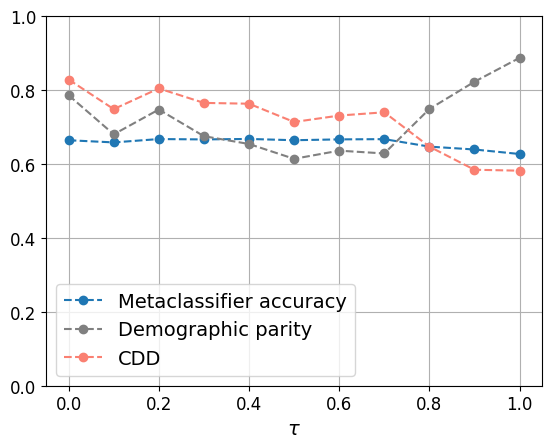

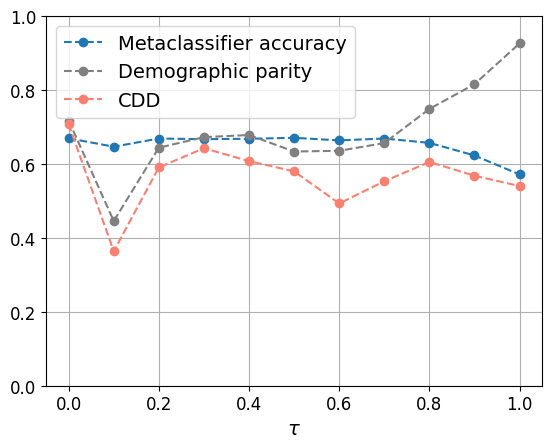

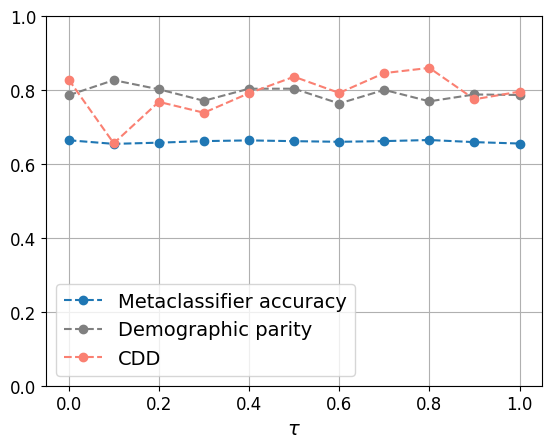

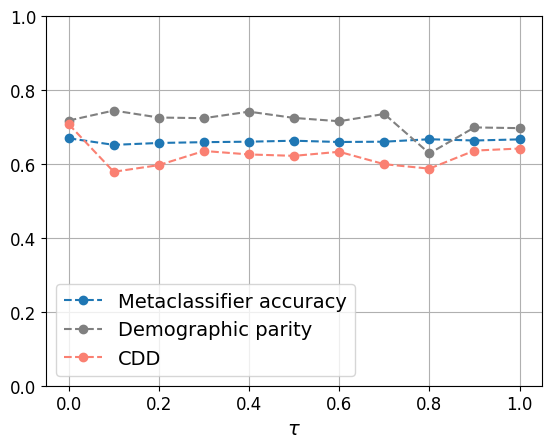

In [76]:
case_study = 'compas_twoyear'
means = {}

axs = axs.ravel()

import itertools
tickers = [combo for combo in itertools.product(all_metrics[case_study].keys(), all_metrics[case_study]['sr'].keys())]

for ticker, i in zip(tickers, range(len(tickers))):

  means_per_tau = pd.DataFrame(index=all_metrics[case_study]['sr']['sex']['FDR'].columns,
                             columns = all_metrics[case_study]['sr']['sex'].keys())
  
  for metric in all_metrics[case_study]['sr']['sex'].keys():
    #print(metric, all_metrics['adult']['sr']['sex'][metric].mean(axis=0), end = '')
    means_per_tau[metric] = all_metrics[case_study][ticker[0]][ticker[1]][metric].mean(axis=0)

  means[ticker] = means_per_tau

  accuracies, statistical_rates, fdr, CDD = means_per_tau['Metaclass. accuracy'].values, means_per_tau['DP'].values, means_per_tau['FDR'].values, means_per_tau['CDD preds unpriv'] 
  all_tau = [float(tau[-3:]) for tau in means_per_tau.index.values]

  import matplotlib.pyplot as plt

  plt.plot(all_tau, accuracies, label = 'Metaclassifier accuracy', linestyle="--",marker="o")
  plt.plot(all_tau, statistical_rates, label = 'Demographic parity', linestyle="--",marker="o", c='grey')
  #plt.plot(all_tau, fdr, label = 'False Discovery Rate', linestyle="--",marker="o", c='green')
  plt.plot(all_tau, CDD, label = 'CDD', linestyle="--",marker="o", c='salmon')
  plt.xlabel(r'$\tau$', size=14)
  plt.tick_params(labelsize = 'large',which='major')
  plt.ylim(bottom=0,top=1)
  #plt.title('Protected att.:'+ticker[1]+' with '+ticker[0]+' constraint', fontsize=14)

  plt.legend(prop={'size':14})
  plt.grid(visible=True)
  
  plt.savefig("Results/Figures/"+case_study+str(ticker[0])+str(ticker[1])+".pdf", format="pdf", bbox_inches="tight")
  #plt.suptitle('Accuracy and metrics for '+case_study+' with '+str(folds)+'fold cross-validation', y=0.95, fontsize='xx-large', fontweight='bold')
  plt.show()

In [74]:
compas_twoyear_tau = [0.9, 0.9, 0.8, 0.7] # tau that reaches trade-off between accuracy and fairness when target is `two_year_recid` 
compas_guess_tau = [0.8, 0.9, 0.8, 0.8] # tau that reaches trade-off between accuracy and fairness when target is `compas_guess`

taus = []
for key, tau in zip(means.keys(), compas_twoyear_tau): # or compas_guess_tau
  taus.append([key, tau])
  l = [case_study, key[0], key[1], 'Random forest']
  [l.append(i) for i in means[key].loc['Tau'+str(tau)].values.round(2)]
  to_append = pd.DataFrame(np.array(l)).T
  to_append.columns = cols
  to_append['Chosen tau'] = str(tau)
  final_results = final_results.append(to_append)

for key, tau in zip(means.keys(), [0.0, 0.0, 0.0, 0.0]):
  taus.append([key, tau])
  l = [case_study, key[0], key[1], 'Random forest']
  [l.append(i) for i in means[key].loc['Tau'+str(tau)].values.round(2)]
  to_append = pd.DataFrame(np.array(l)).T
  to_append.columns = cols_0
  final_results_tau0 = final_results_tau0.append(to_append)

add_tau0 = final_results_tau0[final_results_tau0.columns[11:]].columns
final_results[add_tau0] = final_results_tau0[add_tau0].values

#### Adult

Take the mean of all folds. 

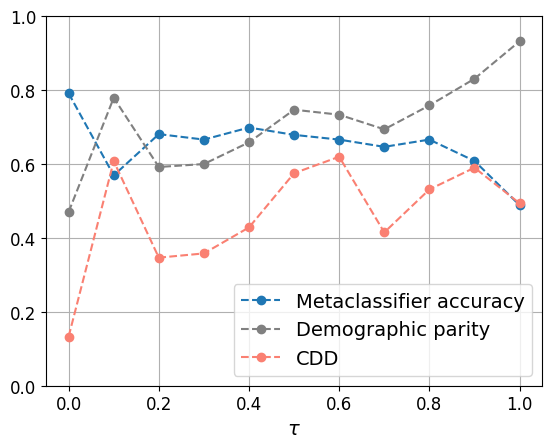

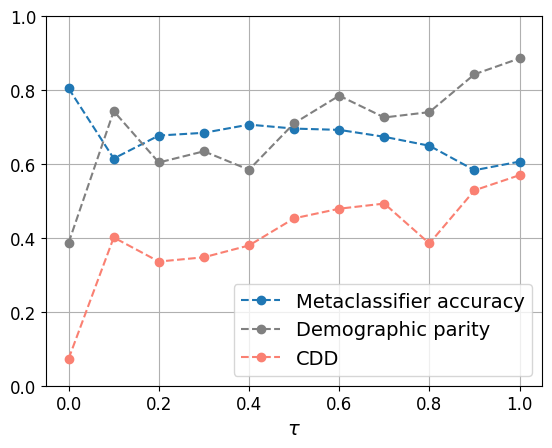

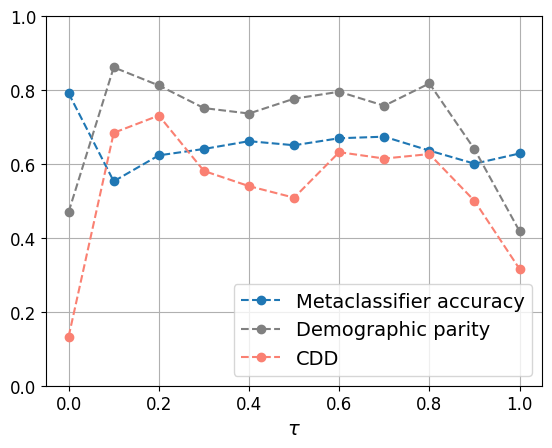

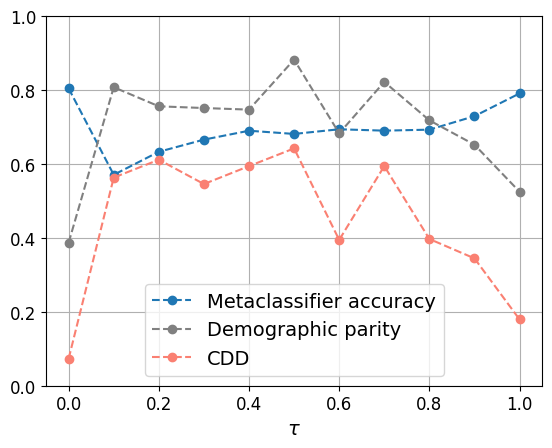

In [77]:
case_study = 'adult'
means = {}

axs = axs.ravel()

import itertools
tickers = [combo for combo in itertools.product(all_metrics[case_study].keys(), all_metrics[case_study]['sr'].keys())]

for ticker, i in zip(tickers, range(len(tickers))):

  means_per_tau = pd.DataFrame(index=all_metrics[case_study]['sr']['sex']['FDR'].columns,
                             columns = all_metrics[case_study]['sr']['sex'].keys())
  
  for metric in all_metrics[case_study]['sr']['sex'].keys():
    #print(metric, all_metrics['adult']['sr']['sex'][metric].mean(axis=0), end = '')
    means_per_tau[metric] = all_metrics[case_study][ticker[0]][ticker[1]][metric].mean(axis=0)

  means[ticker] = means_per_tau

  accuracies, statistical_rates, fdr, CDD = means_per_tau['Metaclass. accuracy'].values, means_per_tau['DP'].values, means_per_tau['FDR'].values, means_per_tau['CDD preds unpriv'] 
  all_tau = [float(tau[-3:]) for tau in means_per_tau.index.values]

  import matplotlib.pyplot as plt

  plt.plot(all_tau, accuracies, label = 'Metaclassifier accuracy', linestyle="--",marker="o")
  plt.plot(all_tau, statistical_rates, label = 'Demographic parity', linestyle="--",marker="o", c='grey')
  #plt.plot(all_tau, fdr, label = 'False Discovery Rate', linestyle="--",marker="o", c='green')
  plt.plot(all_tau, CDD, label = 'CDD', linestyle="--",marker="o", c='salmon')
  plt.xlabel(r'$\tau$', size=14)
  plt.tick_params(labelsize = 'large',which='major')
  plt.ylim(bottom=0,top=1)
  #plt.title('Protected att.:'+ticker[1]+' with '+ticker[0]+' constraint', fontsize=14)

  plt.legend(prop={'size':14})
  plt.grid(visible=True)
  
  plt.savefig("Results/Figures/"+case_study+str(ticker[0])+str(ticker[1])+".pdf", format="pdf", bbox_inches="tight")
  #plt.suptitle('Accuracy and metrics for '+case_study+' with '+str(folds)+'fold cross-validation', y=0.95, fontsize='xx-large', fontweight='bold')
  plt.show()

In [78]:
adult_tau = [0.6, 0.7, 0.8, 0.8]

taus = []          
for key, tau in zip(means.keys(), adult_tau):
  taus.append([key, tau])
  l = [case_study, key[0], key[1], 'Random forest']
  [l.append(i) for i in means[key].loc['Tau'+str(tau)].values.round(2)]
  to_append = pd.DataFrame(np.array(l)).T
  to_append.columns = cols
  to_append['Chosen tau'] = str(tau)
  final_results = final_results.append(to_append)

for key, tau in zip(means.keys(), [0.0, 0.0, 0.0, 0.0]):
  taus.append([key, tau])
  l = [case_study, key[0], key[1], 'Random forest']
  [l.append(i) for i in means[key].loc['Tau'+str(tau)].values.round(2)]
  to_append = pd.DataFrame(np.array(l)).T
  to_append.columns = cols_0
  final_results_tau0 = final_results_tau0.append(to_append)

add_tau0 = final_results_tau0[final_results_tau0.columns[11:]].columns
final_results[add_tau0] = final_results_tau0[add_tau0].values

## Final results

In [79]:
final_results[final_results['Constraint'] == 'sr'][['Dataset','Protected att.', 'Metaclass. accuracy', 'DP AT', 'CDD AT unpriv','Chosen tau',
                                                    'Metaclass. accuracy Tau0', 'DP AT Tau0', 'DP GT test', 'CDD GT test unpriv']]

,Dataset,Protected att.,Metaclass. accuracy,DP AT,CDD AT unpriv,Chosen tau,Metaclass. accuracy Tau0,DP AT Tau0,DP GT test,CDD GT test unpriv
0,compas_guess,sex,0.7,0.8,0.86,0.8,0.73,0.84,0.93,0.97
0,compas_guess,race,0.64,0.79,0.63,0.9,0.73,0.58,0.64,0.73
0,compas_twoyear,sex,0.64,0.82,0.58,0.9,0.66,0.79,0.8,0.93
0,compas_twoyear,race,0.62,0.82,0.57,0.9,0.67,0.72,0.8,0.89
0,adult,sex,0.67,0.73,0.62,0.6,0.79,0.47,0.35,0.35
0,adult,race,0.67,0.73,0.49,0.7,0.8,0.39,0.61,0.6
